# Display episode statistics over training

In [1]:
from collections import Counter
import json
import os

import pandas as pd

import matplotlib.pyplot as plt

from simulator.game.connect import Config, State, Action
from alphazero.data import Turn

In [2]:
# Choose session
session_folder = "../sessions/foo/"

In [3]:
# Load episodes and their metadata
path = os.path.join(session_folder, "episode.jl")
config = Config(6, 7, 4)
episodes = []
with open(path, "r") as file:
    for line in file:
        episode_data = json.loads(line)
        turns = [Turn.from_dict(turn_data, config) for turn_data in episode_data["turns"]]
        del episode_data["turns"]
        episode = turns, episode_data
        episodes.append(episode)

In [4]:
# Extract episode-level information as frame
rows = []
for index, (turns, metadata) in enumerate(episodes):
    row = {
        "index": index,
        **metadata,
        "length": len(turns),
        "value": turns[0].value[0],
    }
    rows.append(row)
df = pd.DataFrame(rows)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df

,index,model_epoch,trainer_epoch,timestamp,length,value
0,0,-1,0,2024-12-31 13:35:58.056041+00:00,17,1.0
1,1,-1,0,2024-12-31 13:35:59.802128+00:00,19,1.0
2,2,-1,0,2024-12-31 13:36:00.978339+00:00,15,1.0
3,3,-1,0,2024-12-31 13:36:02.778910+00:00,20,-1.0
4,4,-1,0,2024-12-31 13:36:04.646568+00:00,22,-1.0
...,...,...,...,...,...,...
6274,6274,1562,1562,2025-01-01 02:40:10.351466+00:00,31,1.0
6275,6275,1562,1563,2025-01-01 02:40:13.732975+00:00,24,-1.0
6276,6276,1562,1563,2025-01-01 02:40:23.920031+00:00,30,-1.0
6277,6277,1562,1563,2025-01-01 02:40:27.038092+00:00,41,1.0


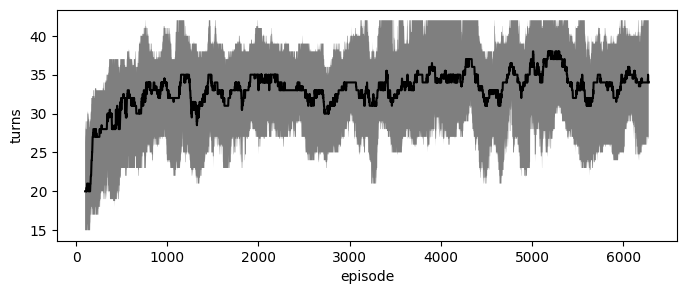

In [5]:
# Show episode length over training
_, ax = plt.subplots(figsize=(8, 3))
median = df["length"].rolling(100).quantile(0.5)
low = df["length"].rolling(100).quantile(0.25)
high = df["length"].rolling(100).quantile(0.75)
ax.fill_between(df["index"], low, high, fc="k", alpha=0.5)
ax.plot(df["index"], median, c="k")
ax.set_xlabel("episode")
ax.set_ylabel("turns")
plt.show()

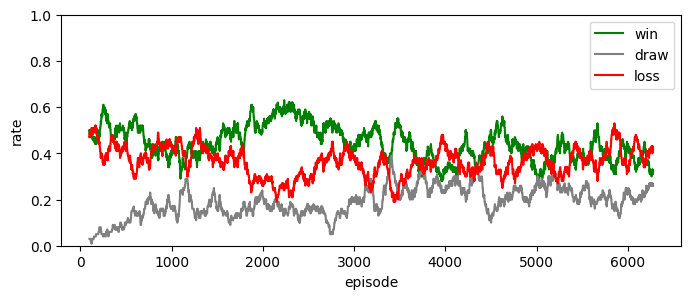

In [6]:
# Show episode outcome proportion over training (w.r.t. first player)
_, ax = plt.subplots(figsize=(8, 3))
ax.plot(df["index"], (df["value"] == 1.0).rolling(100).mean(), c="g", label="win")
ax.plot(df["index"], (df["value"] == 0.0).rolling(100).mean(), c="gray", label="draw")
ax.plot(df["index"], (df["value"] == -1.0).rolling(100).mean(), c="r", label="loss")
ax.set_xlabel("episode")
ax.set_ylabel("rate")
ax.set_ylim(0.0, 1.0)
plt.legend()
plt.show()

In [7]:
# Count individual states
counter = Counter(turn.state for turns, _ in episodes for turn in turns)
len(counter), sum(counter.values())

(133721, 197759)

In [8]:
# Pick arbitrary state
config = Config(6, 7, 4)
state = State.from_json(
    {
        "grid": [
            [1, -1, 1, 0, -1, 0, 1],
            [-1, -1, 0, 1, -1, 0, -1],
            [-1, -1, 1, 0, -1, 1, -1],
            [-1, -1, 0, 1, -1, 0, -1],
            [-1, -1, -1, 0, -1, 1, -1],
            [-1, -1, -1, 0, -1, -1, -1],
        ],
        "player": 1,
    },
    config,
)

In [9]:
# How many times it was played
counter[state]

7

In [10]:
# Extract turn-level information as frame
rows = []
for index, (episode, metadata) in enumerate(episodes):
    for turn in episode:
        if turn.state == state:
            break
    else:
        continue
    row = {
        "index": index,
        **metadata,
        "value": turn.value[0],
    }
    for action, probability in turn.policy.items():
        row[action.column] = probability
    rows.append(row)
df = pd.DataFrame(rows)
df["timestamp"] = pd.to_datetime(df["timestamp"])
df

,index,model_epoch,trainer_epoch,timestamp,value,0,1,2,4,5,6
0,2899,702,703,2024-12-31 19:29:42.484216+00:00,1.0,0.014014,0.010010,0.328328,0.019019,0.549550,0.079079
1,2957,717,718,2024-12-31 19:37:23.876315+00:00,1.0,0.009009,0.005005,0.447447,0.021021,0.155155,0.362362
2,2959,718,718,2024-12-31 19:37:35.726603+00:00,1.0,0.010010,0.004004,0.284284,0.012012,0.062062,0.627628
3,2994,728,728,2024-12-31 19:42:36.919685+00:00,1.0,0.011011,0.006006,0.150150,0.015015,0.386386,0.431431
4,3043,739,740,2024-12-31 19:48:12.078302+00:00,1.0,0.043043,0.005005,0.077077,0.027027,0.680681,0.167167
5,3054,741,742,2024-12-31 19:49:24.831964+00:00,1.0,0.096096,0.005005,0.209209,0.029029,0.484484,0.176176
6,3124,761,761,2024-12-31 19:59:08.835872+00:00,1.0,0.123123,0.012012,0.142142,0.023023,0.497497,0.202202
